In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()

In [3]:


# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?
device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embed = 10
n_hidden = 200



g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g).to(device) 
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).to(device) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g).to(device) * 0.1
W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device) * 0.01
b2 = torch.randn(vocab_size, generator=g).to(device) * 0

bngain = torch.randn((1, n_hidden)).to(device)* 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)).to(device)*0.1
bnmean_running = torch.zeros((1, n_hidden)).to(device)
bnstd_running = torch.ones((1, n_hidden)).to(device)
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [8]:
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g).to(device)
Xb, Yb = Xtr[ix], Ytr[ix]

In [47]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# linear
hprebn = embcat @ W1 + b1
# batchnorm
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # bessel's correction, why?
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

#nonlinearity
h = torch.tanh(hpreact)

#second linear layer
logits = h @ W2 + b2
# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, 
          logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, 
          bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss


tensor(3.2796, device='mps:0', grad_fn=<NegBackward0>)

In [15]:
counts_sum_inv.shape, dprobs.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

In [54]:
# backprop through eavh value of the network

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts = torch.ones_like(counts) * dcounts_sum + dcounts
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits 
db2 = dlogits.sum(0)

dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff = bnvar_inv * dbnraw
dbndiff2 = (1/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2*bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += torch.ones_like(hprebn) * (1.0/n * dbnmeani)

dembcat = dhprebn @ W1.T 
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-10
bngain          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bnbias          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bnraw  

In [55]:
# fused cross entropy loss
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.238689482212067e-09


In [57]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-10


In [63]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g).to(device) 
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).to(device) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g).to(device) * 0.1
W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device) * 0.01
b2 = torch.randn(vocab_size, generator=g).to(device) * 0

bngain = torch.randn((1, n_hidden)).to(device)* 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)).to(device)*0.1
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
max_steps = 20000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():
    for i in range(max_steps):

        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g).to(device)
        Xb, Yb = Xtr[ix], Ytr[ix]
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        # linear
        hprebn = embcat @ W1 + b1
        # batchnorm
        bnmeani = 1/n*hprebn.sum(0, keepdim=True)
        bndiff = hprebn - bnmeani
        bndiff2 = bndiff**2
        bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # bessel's correction, why?
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = bndiff * bnvar_inv
        hpreact = bngain * bnraw + bnbias

        #nonlinearity
        h = torch.tanh(hpreact)

        #second linear layer
        logits = h @ W2 + b2
        # cross entropy loss
        loss = F.cross_entropy(logits, Yb)

        # #pytorch backprop
        # for p in parameters:
        #     p.grad = None
        # loss.backward()
        # backprop
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n

        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits 
        db2 = dlogits.sum(0)

        dhpreact = (1 - h**2) * dh

        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

        dembcat = dhprebn @ W1.T 
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)

        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        lr = 0.1 if i < 1000 else 0.01
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad
        
        if i % 100 == 0:
            print(i, loss.item())
        # if i > 1000: break

0 3.2822604179382324
100 2.6350820064544678
200 2.527113199234009
300 2.610959053039551
400 2.553684711456299
500 2.2009024620056152
600 2.5079731941223145
700 2.480609893798828
800 2.3960559368133545
900 2.2991435527801514
1000 2.706491470336914
1100 2.6886959075927734
1200 2.3684139251708984
1300 2.162968635559082
1400 2.0877132415771484
1500 2.12772798538208
1600 2.555929183959961
1700 2.6632156372070312
1800 2.012120246887207
1900 2.4451467990875244
2000 2.171506881713867


KeyboardInterrupt: 

In [62]:
for p, g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.30385160446167e-08
(50, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [81]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [64]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# + b1
    # batch norm
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnmean_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.0467021465301514
val 3.0544471740722656


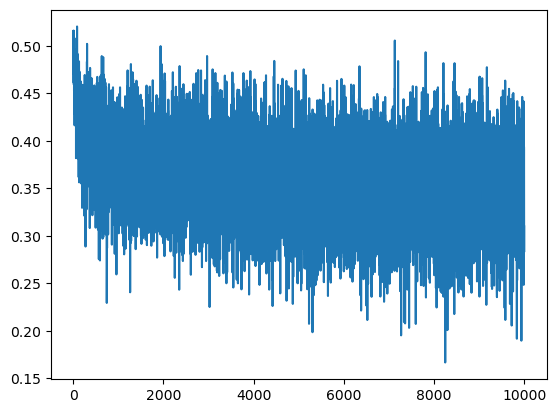

In [32]:
plt.plot(stepi, lossi)

In [65]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).to(device).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))



gzcutjangrilevzenggn.
bnemqhrwce.
rphlccersignjebcqhjexnnlxch.
rjwis.
juzzry.
malevlengscevnapkibnneqhatreagmues.
kbrelwhxlynaloh.
darivm.
jazxh.
zqerarm.
klssubnnkggynnnd.
mazldynn.
mruiebtstljnn.
bryqya.
bvcezpkchakfejlynahndvash.
juuhllartin.
jybcexcfnd.
dadrinnxzfn.
jalannelgmbkwfelfndghllanilfadchnklyllulglelshoxryndelilg.
kshvan.


(array([232., 147., 104., 128., 114., 107.,  97.,  89., 112., 107., 101.,
        102., 108.,  95., 111., 136., 133., 119., 103., 153., 111., 139.,
        160., 159., 147., 138., 172., 138., 148., 140., 117., 134., 122.,
        124., 128.,  98., 136., 109., 104., 101.,  92.,  96., 105., 127.,
        106., 127., 105., 144., 163., 312.]),
 array([-9.99885738e-01, -9.59888110e-01, -9.19890482e-01, -8.79892855e-01,
        -8.39895227e-01, -7.99897599e-01, -7.59899971e-01, -7.19902344e-01,
        -6.79904716e-01, -6.39907088e-01, -5.99909461e-01, -5.59911833e-01,
        -5.19914205e-01, -4.79916577e-01, -4.39918950e-01, -3.99921322e-01,
        -3.59923694e-01, -3.19926066e-01, -2.79928439e-01, -2.39930811e-01,
        -1.99933183e-01, -1.59935555e-01, -1.19937928e-01, -7.99403000e-02,
        -3.99426723e-02,  5.49554825e-05,  4.00525832e-02,  8.00502110e-02,
         1.20047839e-01,  1.60045466e-01,  2.00043094e-01,  2.40040722e-01,
         2.80038350e-01,  3.20035977e-01,  3.60033

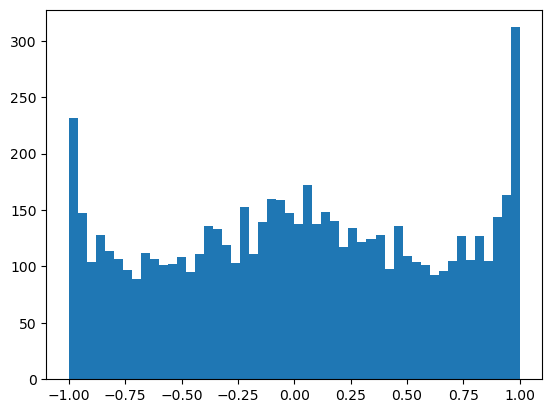

In [13]:


# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')
plt.hist(h.view(-1).tolist(), 50)


(array([  1.,   1.,   1.,   2.,   3.,   2.,   5.,  11.,  24.,  20.,  48.,
         58.,  69., 112., 155., 186., 191., 235., 298., 312., 378., 418.,
        468., 457., 401., 350., 386., 309., 326., 260., 190., 150., 166.,
        125.,  98.,  66.,  36.,  24.,  19.,  15.,   7.,   5.,   3.,   2.,
          3.,   0.,   1.,   0.,   0.,   3.]),
 array([-24.9390564 , -23.86091011, -22.78276382, -21.70461754,
        -20.62647125, -19.54832497, -18.47017868, -17.39203239,
        -16.31388611, -15.23573982, -14.15759354, -13.07944725,
        -12.00130096, -10.92315468,  -9.84500839,  -8.76686211,
         -7.68871582,  -6.61056953,  -5.53242325,  -4.45427696,
         -3.37613068,  -2.29798439,  -1.2198381 ,  -0.14169182,
          0.93645447,   2.01460075,   3.09274704,   4.17089333,
          5.24903961,   6.3271859 ,   7.40533218,   8.48347847,
          9.56162476,  10.63977104,  11.71791733,  12.79606361,
         13.8742099 ,  14.95235619,  16.03050247,  17.10864876,
         18.186795

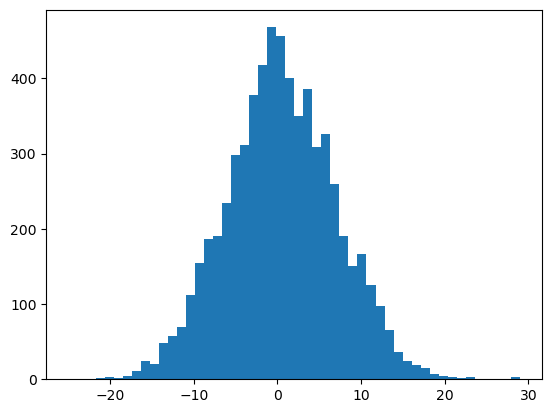

In [21]:

plt.hist(hpreact.view(-1).tolist(), 50)